![BTS](https://github.com/vfp1/bts-dsf-2020/raw/main/Logo-BTS.jpg)

# Session 12: The Road to ML application
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Data Science Foundations (2020-12-10)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-dsf-2020/blob/main/Session_12/Session_12_The_Road_to_ML_application.ipynb)

**Resources:**

*   Jake VanderPlass
*   Aurelien Geron
*   SKLEARN docs
*   Victor PM


# A full understanding of Scikit-learn API

We will start by covering *data representation* in Scikit-Learn, followed by covering the *Estimator* API, and finally go through a more interesting example of using these tools for exploring a set of images of hand-written digits.

## Data Representation in Scikit-Learn

Machine learning is about creating models from data: for that reason, we'll start by discussing how data can be represented in order to be understood by the computer.
The best way to think about data within Scikit-Learn is in terms of tables of data.

### Data as table

A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements.
For example, consider the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), famously analyzed by Ronald Fisher in 1936.
We can download this dataset in the form of a Pandas ``DataFrame`` using the [seaborn](http://seaborn.pydata.org/) library:

In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Here each row of the data refers to a single observed flower, and the number of rows is the total number of flowers in the dataset.
In general, we will refer to the rows of the matrix as *samples*, and the number of rows as ``n_samples``.

Likewise, each column of the data refers to a particular quantitative piece of information that describes each sample.
In general, we will refer to the columns of the matrix as *features*, and the number of columns as ``n_features``.

#### Features matrix

This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the *features matrix*.
By convention, this features matrix is often stored in a variable named ``X``.
The features matrix is assumed to be two-dimensional, with shape ``[n_samples, n_features]``, and is most often contained in a NumPy array or a Pandas ``DataFrame``, though some Scikit-Learn models also accept SciPy sparse matrices.

The samples (i.e., rows) always refer to the individual objects described by the dataset.
For example, the sample might be a flower, a person, a document, an image, a sound file, a video, an astronomical object, or anything else you can describe with a set of quantitative measurements.

The features (i.e., columns) always refer to the distinct observations that describe each sample in a quantitative manner.
Features are generally real-valued, but may be Boolean or discrete-valued in some cases.

#### Target array

In addition to the feature matrix ``X``, we also generally work with a *label* or *target* array, which by convention we will usually call ``y``.
The target array is usually one dimensional, with length ``n_samples``, and is generally contained in a NumPy array or Pandas ``Series``.
The target array may have continuous numerical values, or discrete classes/labels.
While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, ``[n_samples, n_targets]`` target array, we will primarily be working with the common case of a one-dimensional target array.

Often one point of confusion is how the target array differs from the other features columns. The distinguishing feature of the target array is that it is usually the quantity we want to *predict from the data*: in statistical terms, it is the dependent variable.
For example, in the preceding data we may wish to construct a model that can predict the species of flower based on the other measurements; in this case, the ``species`` column would be considered the target array.

With this target array in mind, we can use Seaborn to conveniently visualize the data:

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


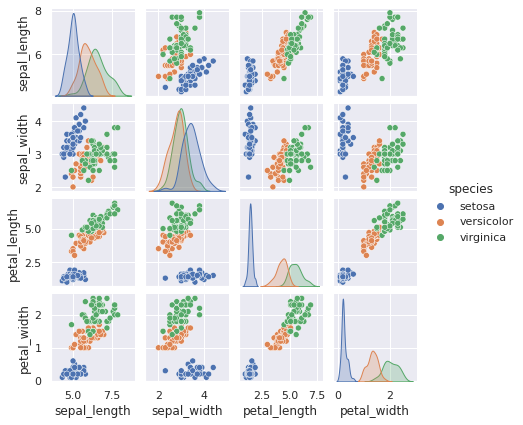

In [2]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.pairplot(iris, hue='species', size=1.5);

For use in Scikit-Learn, we will extract the features matrix and target array from the ``DataFrame``, which we can do using some of the Pandas ``DataFrame``:

In [3]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [4]:
y_iris = iris['species']
y_iris.shape

(150,)

To summarize, the expected layout of features and target values is visualized in the following diagram:

(10.0, -2.0)

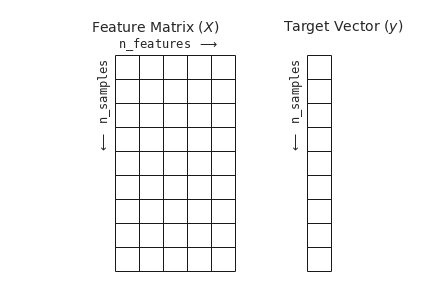

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.axis('equal')

# Draw features matrix
ax.vlines(range(6), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=0, xmax=5, lw=1)
font_prop = dict(size=12, family='monospace')
ax.text(-1, -1, "Feature Matrix ($X$)", size=14)
ax.text(0.1, -0.3, r'n_features $\longrightarrow$', **font_prop)
ax.text(-0.1, 0.1, r'$\longleftarrow$ n_samples', rotation=90,
        va='top', ha='right', **font_prop)

# Draw labels vector
ax.vlines(range(8, 10), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=8, xmax=9, lw=1)
ax.text(7, -1, "Target Vector ($y$)", size=14)
ax.text(7.9, 0.1, r'$\longleftarrow$ n_samples', rotation=90,
        va='top', ha='right', **font_prop)

ax.set_ylim(10, -2)


With this data properly formatted, we can move on to consider the *estimator* API of Scikit-Learn:

## Scikit-Learn's Estimator API

The Scikit-Learn API is designed with the following guiding principles in mind, as outlined in the [Scikit-Learn API paper](http://arxiv.org/abs/1309.0238):

- *Consistency*: All objects share a common interface drawn from a limited set of methods, with consistent documentation.

- *Inspection*: All specified parameter values are exposed as public attributes.

- *Limited object hierarchy*: Only algorithms are represented by Python classes; datasets are represented
  in standard formats (NumPy arrays, Pandas ``DataFrame``s, SciPy sparse matrices) and parameter
  names use standard Python strings.

- *Composition*: Many machine learning tasks can be expressed as sequences of more fundamental algorithms,
  and Scikit-Learn makes use of this wherever possible.

- *Sensible defaults*: When models require user-specified parameters, the library defines an appropriate default value.

In practice, these principles make Scikit-Learn very easy to use, once the basic principles are understood.
Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through several simple examples of applying supervised and unsupervised learning methods.

### What type of learning do I use?

At the most fundamental level, machine learning can be categorized into two main types: supervised learning and unsupervised learning.

**Supervised learning** involves somehow modeling the relationship between measured features of data and some label associated with the data; once this model is determined, it can be used to apply labels to new, unknown data. This is further subdivided into classification tasks and regression tasks: in classification, the labels are discrete categories, while in regression, the labels are continuous quantities. We will see examples of both types of supervised learning in the following section.

**Unsupervised learning** involves modeling the features of a dataset without reference to any label, and is often described as "letting the dataset speak for itself." These models include tasks such as clustering and dimensionality reduction. Clustering algorithms identify distinct groups of data, while dimensionality reduction algorithms search for more succinct representations of the data. We will see examples of both types of unsupervised learning in the following section.

In addition, there are so-called semi-supervised learning methods, which falls somewhere between supervised learning and unsupervised learning. Semi-supervised learning methods are often useful when only incomplete labels are available.

*  **Supervised learning**: Models that can predict labels based on labeled training data

    *  **Classification**: Models that predict labels as two or more discrete categories
    *  **Regression**: Models that predict continuous labels

*  **Unsupervised learning**: Models that identify structure in unlabeled data

    *  **Clustering**: Models that detect and identify distinct groups in the data
    *  **Dimensionality reduction**: Models that detect and identify lower-dimensional structure in higher-dimensional data

### Supervised learning example: Simple linear regression

As an example of this process, let's consider a simple linear regression—that is, the common case of fitting a line to $(x, y)$ data.
We will use the following simple data for our regression example:

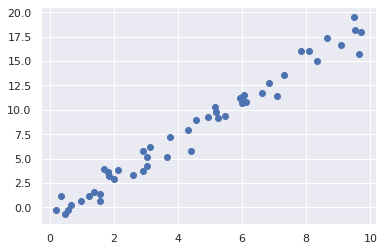

In [6]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 2 * x - 1 + rng.randn(50)
plt.scatter(x, y);

With this data in place, we can use the recipe outlined earlier. Let's walk through the process: 

#### 1. Choose a class of model

In Scikit-Learn, every class of model is represented by a Python class.
So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class:

In [7]:
from sklearn.linear_model import LinearRegression

Note that other more general linear regression models exist as well; you can read more about them in the [``sklearn.linear_model`` module documentation](http://Scikit-Learn.org/stable/modules/linear_model.html).

#### 2. Choose model hyperparameters

An important point is that *a class of model is not the same as an instance of a model*.

Once we have decided on our model class, there are still some options open to us.
Depending on the model class we are working with, we might need to answer one or more questions like the following:

- Would we like to fit for the offset (i.e., *y*-intercept)?
- Would we like the model to be normalized?
- Would we like to preprocess our features to add model flexibility?
- What degree of regularization would we like to use in our model?
- How many model components would we like to use?

These are examples of the important choices that must be made *once the model class is selected*.
These choices are often represented as *hyperparameters*, or parameters that must be set before the model is fit to data.
In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation..

For our linear regression example, we can instantiate the ``LinearRegression`` class and specify that we would like to fit the intercept using the ``fit_intercept`` hyperparameter:

In [18]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

![intercept](https://i.stack.imgur.com/P3mN9.png)



Keep in mind that when the model is instantiated, the only action is the storing of these hyperparameter values.
In particular, we have not yet applied the model to any data: the Scikit-Learn API makes very clear the distinction between *choice of model* and *application of model to data*.

#### 3. Arrange data into a features matrix and target vector

Previously we detailed the Scikit-Learn data representation, which requires a two-dimensional features matrix and a one-dimensional target array.
Here our target variable ``y`` is already in the correct form (a length-``n_samples`` array), but we need to massage the data ``x`` to make it a matrix of size ``[n_samples, n_features]``.
In this case, this amounts to a simple reshaping of the one-dimensional array:

In [19]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### 4. Fit the model to your data

Now it is time to apply our model to data.
This can be done with the ``fit()`` method of the model:

In [20]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

This ``fit()`` command causes a number of model-dependent internal computations to take place, and the results of these computations are stored in model-specific attributes that the user can explore.
In Scikit-Learn, by convention all model parameters that were learned during the ``fit()`` process have trailing underscores; for example in this linear model, we have the following:

In [21]:
model.coef_

array([1.9776566])

In [22]:
model.intercept_

-0.9033107255311146

These two parameters represent the slope and intercept of the simple linear fit to the data.
Comparing to the data definition, we see that they are very close to the input slope of 2 and intercept of -1.

One question that frequently comes up regards the uncertainty in such internal model parameters.
In general, Scikit-Learn does not provide tools to draw conclusions from internal model parameters themselves: interpreting model parameters is much more a *statistical modeling* question than a *machine learning* question.
Machine learning rather focuses on what the model *predicts*.
If you would like to dive into the meaning of fit parameters within the model, other tools are available, including the [Statsmodels Python package](http://statsmodels.sourceforge.net/).

#### 5. Predict labels for unknown data

Once the model is trained, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set.
In Scikit-Learn, this can be done using the ``predict()`` method.
For the sake of this example, our "new data" will be a grid of *x* values, and we will ask what *y* values the model predicts:

In [23]:
xfit = np.linspace(-1, 11)

As before, we need to coerce these *x* values into a ``[n_samples, n_features]`` features matrix, after which we can feed it to the model:

In [24]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

Finally, let's visualize the results by plotting first the raw data, and then this model fit:

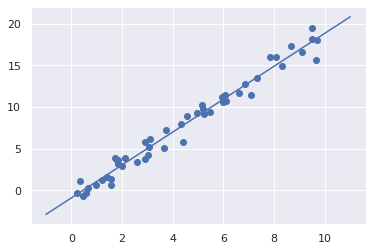

In [25]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

Typically the efficacy of the model is evaluated by comparing its results to some known baseline, as we will see in the next example

### Supervised learning example: Iris classification

Let's take a look at another example of this process, using the Iris dataset we discussed earlier.
Our question will be this: given a model trained on a portion of the Iris data, how well can we predict the remaining labels?

For this task, we will use an extremely simple generative model known as Gaussian naive Bayes, which proceeds by assuming each class is drawn from an axis-aligned Gaussian distribution.

Because it is so fast and has no hyperparameters to choose, Gaussian naive Bayes is often a good model to use as a baseline classification, before exploring whether improvements can be found through more sophisticated models.

We would like to evaluate the model on data it has not seen before, and so we will split the data into a *training set* and a *testing set*.
This could be done by hand, but it is more convenient to use the ``train_test_split`` utility function:

In [26]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris,
                                                random_state=1)

With the data arranged, we can follow our recipe to predict the labels:

In [27]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

Finally, we can use the ``accuracy_score`` utility to see the fraction of predicted labels that match their true value:

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9736842105263158

With an accuracy topping 97%, we see that even this very naive classification algorithm is effective for this particular dataset!

### Unsupervised learning example: Iris dimensionality

As an example of an unsupervised learning problem, let's take a look at reducing the dimensionality of the Iris data so as to more easily visualize it.
Recall that the Iris data is four dimensional: there are four features recorded for each sample.

The task of dimensionality reduction is to ask whether there is a suitable lower-dimensional representation that retains the essential features of the data.
Often dimensionality reduction is used as an aid to visualizing data: after all, it is much easier to plot data in two dimensions than in four dimensions or higher!

Here we will use principal component analysis, which is a fast linear dimensionality reduction technique.
We will ask the model to return two components—that is, a two-dimensional representation of the data.

Following the sequence of steps outlined earlier, we have:

In [29]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_iris)         # 4. Transform the data to two dimensions

Now let's plot the results. A quick way to do this is to insert the results into the original Iris ``DataFrame``, and use Seaborn's ``lmplot`` to show the results:

In [30]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [31]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,PCA1,PCA2
0,5.1,3.5,1.4,0.2,setosa,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,setosa,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,setosa,-2.888991,-0.144949
3,4.6,3.1,1.5,0.2,setosa,-2.745343,-0.318299
4,5.0,3.6,1.4,0.2,setosa,-2.728717,0.326755


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


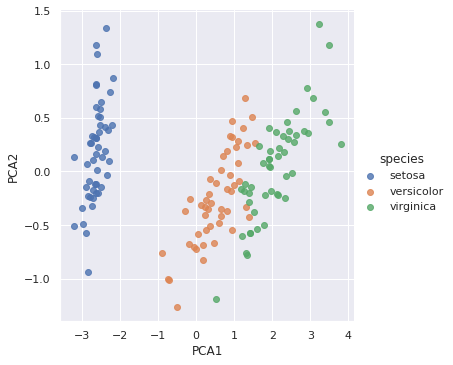

In [32]:
sns.lmplot("PCA1", "PCA2", hue='species', data=iris, fit_reg=False);

We see that in the two-dimensional representation, the species are fairly well separated, even though the PCA algorithm had no knowledge of the species labels!
This indicates to us that a relatively straightforward classification will probably be effective on the dataset, as we saw before.

### Unsupervised learning: Iris clustering

Let's next look at applying clustering to the Iris data.
A clustering algorithm attempts to find distinct groups of data without reference to any labels.
Here we will use a powerful clustering method called a Gaussian mixture model (GMM).
A GMM attempts to model the data as a collection of Gaussian blobs.

We can fit the Gaussian mixture model as follows:

In [33]:
from sklearn.mixture import GaussianMixture    # 1. Choose the model class
model = GaussianMixture(n_components=3,
            covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                    # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(X_iris)        # 4. Determine cluster labels

As before, we will add the cluster label to the Iris ``DataFrame`` and use Seaborn to plot the results:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


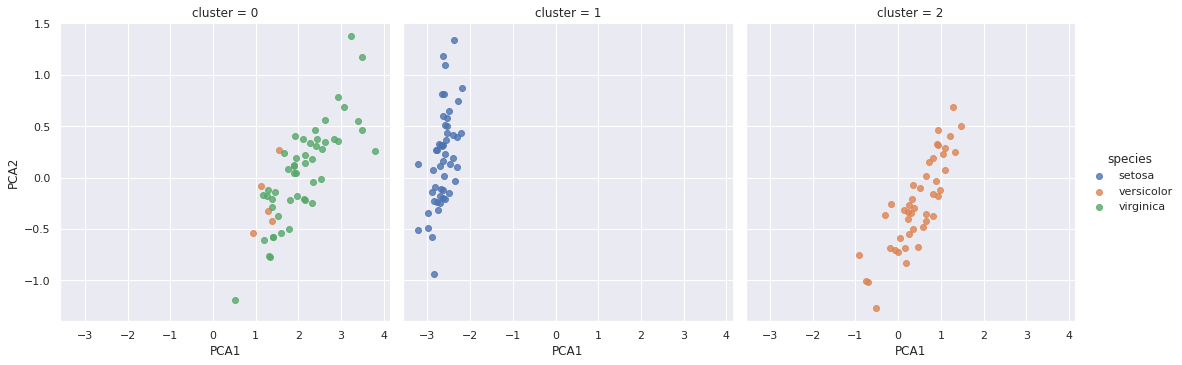

In [34]:
iris['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=iris, hue='species',
           col='cluster', fit_reg=False);

By splitting the data by cluster number, we see exactly how well the GMM algorithm has recovered the underlying label: the *setosa* species is separated perfectly within cluster 0, while there remains a small amount of mixing between *versicolor* and *virginica*.
This means that even without an expert to tell us the species labels of the individual flowers, the measurements of these flowers are distinct enough that we could *automatically* identify the presence of these different groups of species with a simple clustering algorithm!
This sort of algorithm might further give experts in the field clues as to the relationship between the samples they are observing.

## Images: Exploring Hand-written Digits

To demonstrate these principles on a more interesting problem, let's consider one piece of the optical character recognition problem: the identification of hand-written digits.
In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

### Loading and visualizing the digits data

We'll use Scikit-Learn's data access interface and take a look at this data:

In [35]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.
Let's visualize the first hundred of these:

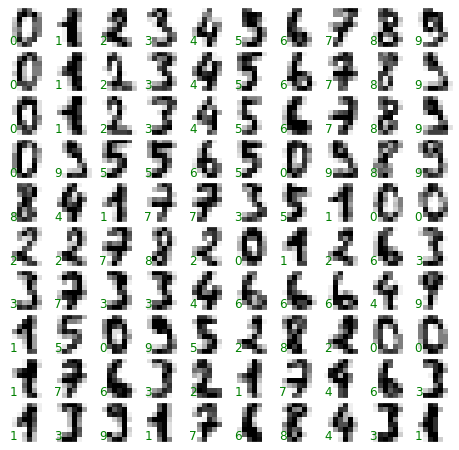

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, ``[n_samples, n_features]`` representation.
We can accomplish this by treating each pixel in the image as a feature: that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit.
Additionally, we need the target array, which gives the previously determined label for each digit.
These two quantities are built into the digits dataset under the ``data`` and ``target`` attributes, respectively:

In [37]:
X = digits.data
X.shape

(1797, 64)

In [38]:
y = digits.target
y.shape

(1797,)

We see here that there are 1,797 samples and 64 features.

### Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space.
Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of a manifold learning algorithm called *Isomap*, and transform the data to two dimensions:

In [39]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

We see that the projected data is now two-dimensional.
Let's plot this data to see if we can learn anything from its structure:

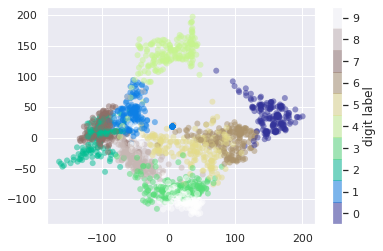

In [40]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('terrain', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

This plot gives us some good intuition into how well various numbers are separated in the larger 64-dimensional space. For example, zeros (in black) and ones (in purple) have very little overlap in parameter space.
Intuitively, this makes sense: a zero is empty in the middle of the image, while a one will generally have ink in the middle.
On the other hand, there seems to be a more or less continuous spectrum between ones and fours: we can understand this by realizing that some people draw ones with "hats" on them, which cause them to look similar to fours.

Overall, however, the different groups appear to be fairly well separated in the parameter space: this tells us that even a very straightforward supervised classification algorithm should perform suitably on this data.
Let's give it a try.

### Classification on digits

Let's apply a classification algorithm to the digits.
As with the Iris data previously, we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [42]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions:

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

With even this extremely simple model, we find about 80% accuracy for classification of the digits!
However, this single number doesn't tell us *where* we've gone wrong—one nice way to do this is to use the *confusion matrix*, which we can compute with Scikit-Learn and plot with Seaborn:

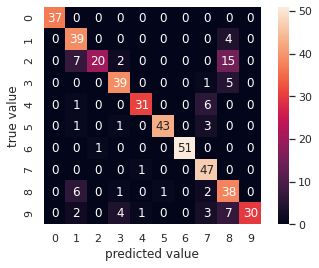

In [44]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

This shows us where the mis-labeled points tend to be: for example, a large number of twos here are mis-classified as either ones or eights.
Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels.
We'll use green for correct labels, and red for incorrect labels:

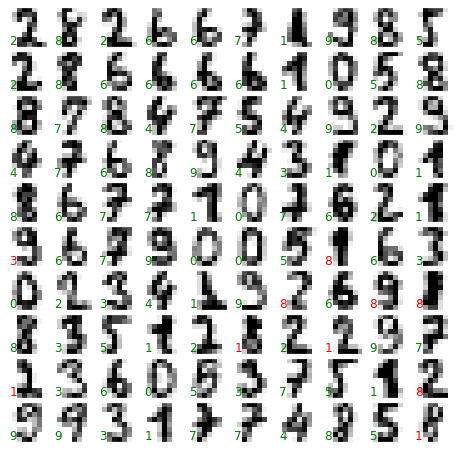

In [45]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

Examining this subset of the data, we can gain insight regarding where the algorithm might be not performing optimally.
To go beyond our 80% classification rate, we might move to a more sophisticated algorithm such as support vector machines, random forests or another classification approach.

## Summary

We have covered the essential features of the Scikit-Learn data representation, and the estimator API.
Regardless of the type of estimator, the same import/instantiate/fit/predict pattern holds.
Armed with this information about the estimator API, you can explore the Scikit-Learn documentation and begin trying out various models on your data.

Now, we will explore perhaps the most important topic in machine learning: how to select and validate your model.

# Hyperparameters and Model Validation

In the previous section, we saw the basic recipe for applying a supervised machine learning model:

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.
In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.
While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

### Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:

In [46]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [47]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [48]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

### Model validation the right way: Holdout sets

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

In [50]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

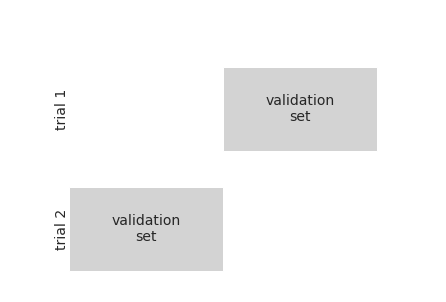

In [51]:
def draw_rects(N, ax, textprop={}):
    for i in range(N):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='white'))
        ax.add_patch(plt.Rectangle((5. * i / N, i), 5. / N, 0.7, fc='lightgray'))
        ax.text(5. * (i + 0.5) / N, i + 0.35,
                "validation\nset", ha='center', va='center', **textprop)
        ax.text(0, i + 0.35, "trial {0}".format(N - i),
                ha='right', va='center', rotation=90, **textprop)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-0.2, N + 0.2)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(2, ax, textprop=dict(size=14))

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

In [52]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

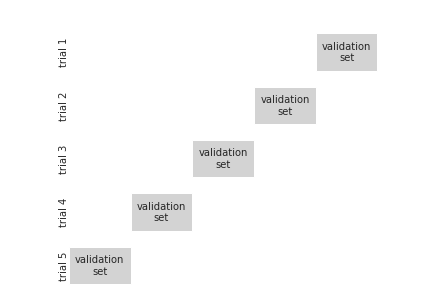

In [53]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(5, ax, textprop=dict(size=10))

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

In [54]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

In [55]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(model, X, y, cv=loo)
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [56]:
scores.mean()

0.96

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Selecting the Best Model

Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

- Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off

Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

In [57]:
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Text(0.5, 1.0, 'High-variance model: Overfits the data')

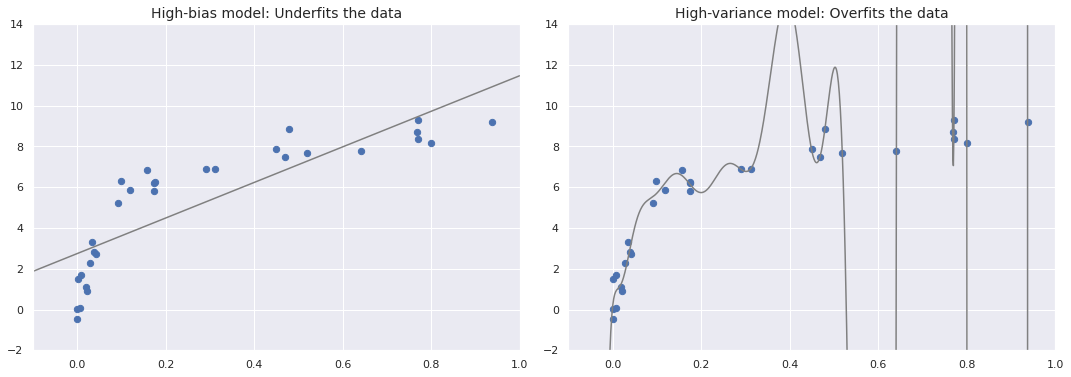

In [59]:
X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

Text(0.02, 0.91, 'validation score: $R^2$ = -1.8e+09')

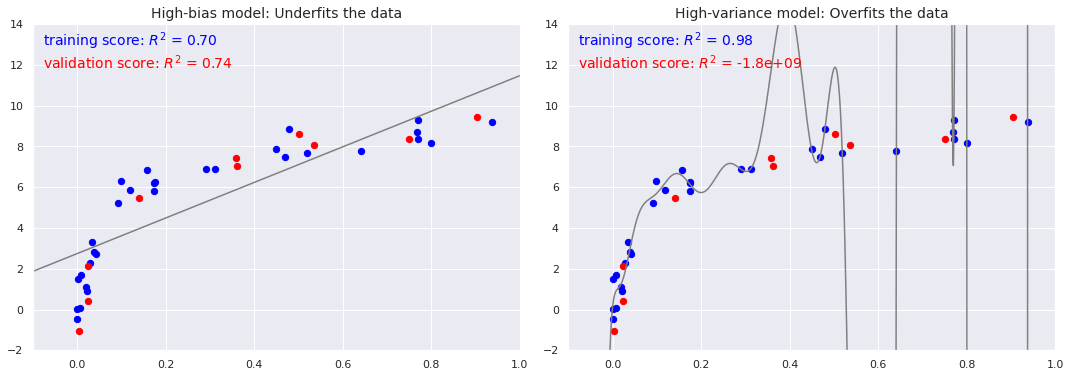

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')


The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

Text(0.5, 1.0, 'Validation Curve Schematic')

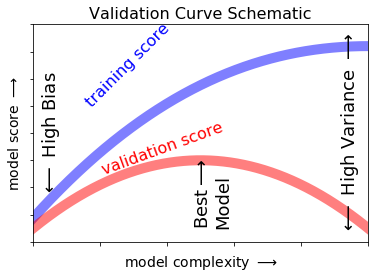

In [ ]:
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots()
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16)

The diagram shown here is often called a *validation curve*, and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.

In [61]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

In [62]:
X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees:

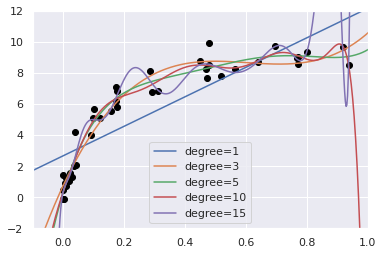

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5, 10, 15]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

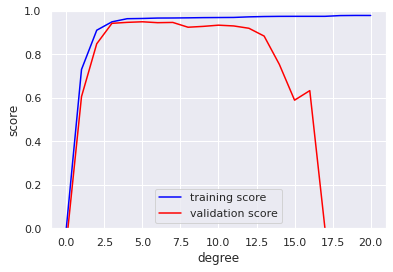

In [64]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

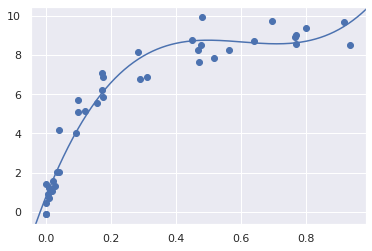

In [65]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

(-0.04687651021505175,
 0.9844070023112612,
 -0.6358426925271523,
 10.458293315197224)

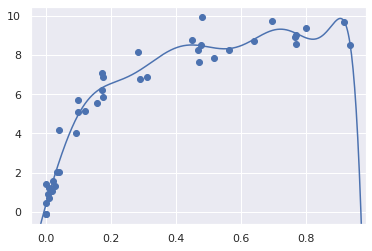

In [67]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(10).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

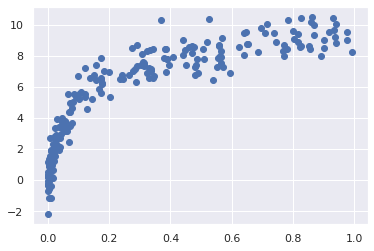

In [76]:
"""
x = np.array([[1, 2, 3], [4, 5, 6]])
np.ravel(x)
array([1, 2, 3, 4, 5, 6])
"""

X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

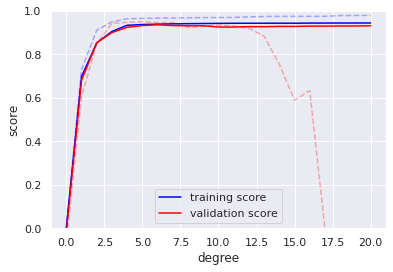

In [77]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

The general behavior we would expect from a learning curve is this:

- A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

Text(0.5, 1.0, 'Learning Curve Schematic')

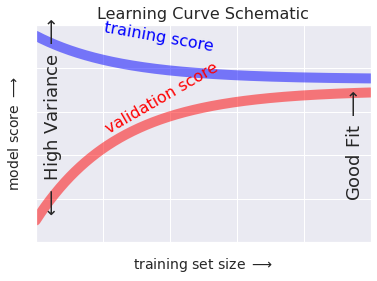

In [79]:
N = np.linspace(0, 1, 1000)
y1 = 0.75 + 0.2 * np.exp(-4 * N)
y2 = 0.7 - 0.6 * np.exp(-4 * N)

fig, ax = plt.subplots()
ax.plot(N, y1, lw=10, alpha=0.5, color='blue')
ax.plot(N, y2, lw=10, alpha=0.5, color='red')

ax.text(0.2, 0.88, "training score", rotation=-10, size=16, color='blue')
ax.text(0.2, 0.5, "validation score", rotation=30, size=16, color='red')

ax.text(0.98, 0.45, r'Good Fit $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.02, 0.57, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel(r'training set size $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Learning Curve Schematic", size=16)


The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

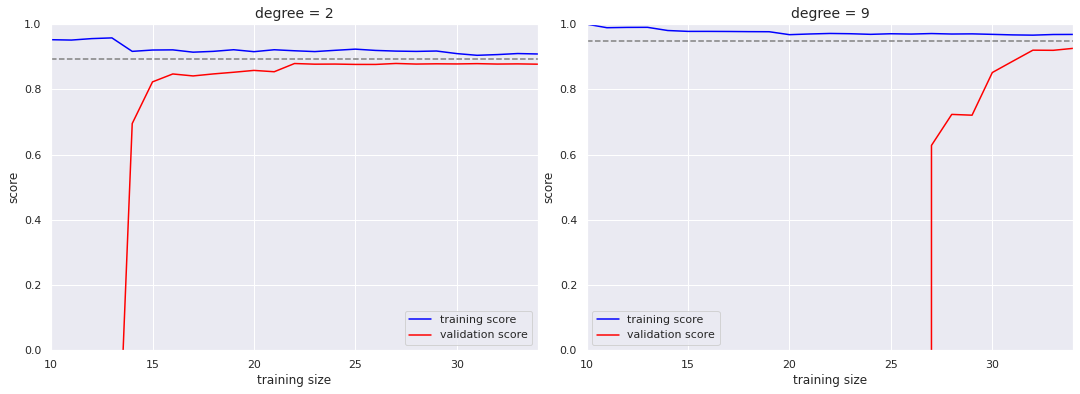

In [81]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

## Validation in Practice: Grid Search

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

In [83]:
grid.fit(X, y);

Now that this is fit, we can ask for the best parameters as follows:

In [84]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': False,
 'polynomialfeatures__degree': 5}

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

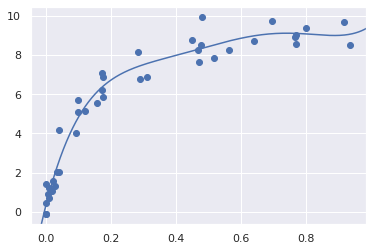

In [85]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim);

The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.
For information, refer to Scikit-Learn's [grid search documentation](http://Scikit-Learn.org/stable/modules/grid_search.html).

## Summary

We have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.

# Model persistence (saving)

After training a scikit-learn model, it is desirable to have a way to persist the model for future use without having to retrain. The following section gives you an example of how to persist a model with pickle. We’ll also review a few security and maintainability issues when working with pickle serialization.

## Using pickle

In [86]:
from sklearn import svm
from sklearn import datasets

clf = svm.SVC(gamma='scale')
iris = datasets.load_iris()
X, y = iris.data, iris.target
clf.fit(X, y)  

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [87]:
import pickle
filename = "final_model.pkl"
pickle.dump(clf, open(filename, 'wb'))

In [88]:
clf2 = pickle.load(open(filename, 'rb'))

In [89]:
clf2.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [90]:
clf2.classes_

array([0, 1, 2])

In [91]:
clf2.predict(X[0:50])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## Using joblib

Joblib is part of the SciPy ecosystem and provides utilities for pipelining Python jobs.

It provides utilities for saving and loading Python objects that make use of NumPy data structures, efficiently.

This can be useful for some machine learning algorithms that require a lot of parameters or store the entire dataset (like K-Nearest Neighbors).

**Reference:** Machine Learning Mastery

In [92]:
from sklearn.externals import joblib

filename_job = "final_model_job.sav"
joblib.dump(clf, filename_job)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['final_model_job.sav']

In [93]:
loaded_model = joblib.load(filename_job)

In [94]:
loaded_model.class_weight_

array([1., 1., 1.])

In [95]:
loaded_model.predict(X[0:50])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## WARNING!!!!!!!

pickle (and joblib by extension), has some issues regarding maintainability and security. Because of this,

* Never unpickle untrusted data as it could lead to malicious code being executed upon loading.
* While models saved using one version of scikit-learn might load in other versions, this is entirely unsupported and inadvisable. It should also be kept in mind that operations performed on such data could give different and unexpected results.
In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:

    * The training data, e.g. a reference to an immutable snapshot
    * The python source code used to generate the model
    * The versions of scikit-learn and its dependencies
    * The cross validation score obtained on the training data

This should make it possible to check that the cross-validation score is in the same range as before.

Since a model internal representation may be different on two different architectures, dumping a model on one architecture and loading it on another architecture is not supported.

In [96]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [97]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [98]:
y_iris = iris['species']
y_iris.shape

(150,)

In [99]:
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

model = svm.SVC(gamma='scale')

Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris,
                                                random_state=1, test_size=0.2)
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(120, 4)
(120,)
(30, 4)
(30,)


In [100]:
model.fit(Xtrain, ytrain)  

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [101]:
score = model.score(Xtest, ytest)
print(score)

0.9666666666666667


In [102]:
tuple_objects = (model, Xtrain, ytrain, Xtest, ytest, score)

# Save tuple
pickle.dump(tuple_objects, open("tuple_model.pkl", 'wb'))

# Restore tuple
pickled_model, pickled_Xtrain, \
pickled_Ytrain, pickled_Xtest, \
pickle_ytest, pickled_score = pickle.load(open("tuple_model.pkl", 'rb'))

In [103]:
pickled_Xtrain.shape

(120, 4)

In [104]:
pickled_model.intercept_

array([ 0.08277028, -0.0747784 , -0.11472885])

## Save model in Keras

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

import keras
from keras import models
from keras import layers

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Creating the Keras model with one neuron
model = models.Sequential()
model.add(layers.Dense(1, activation=None, input_shape=(1,)))

model.compile(optimizer=keras.optimizers.Adam(lr=0.01), 
              loss='mean_squared_error', metrics=['accuracy'])

model.fit(diabetes_X_train, diabetes_y_train, epochs=10, batch_size=1)

Epoch 1/10
422/422 [==============================] - 0s 730us/step - loss: 28881.4297 - accuracy: 0.0000e+00
Epoch 2/10
422/422 [==============================] - 0s 737us/step - loss: 27765.5488 - accuracy: 0.0000e+00
Epoch 3/10
422/422 [==============================] - 0s 736us/step - loss: 26690.9023 - accuracy: 0.0000e+00
Epoch 4/10
422/422 [==============================] - 0s 734us/step - loss: 25655.1113 - accuracy: 0.0000e+00
Epoch 5/10
422/422 [==============================] - 0s 716us/step - loss: 24660.2305 - accuracy: 0.0000e+00
Epoch 6/10
422/422 [==============================] - 0s 705us/step - loss: 23697.6367 - accuracy: 0.0000e+00
Epoch 7/10
422/422 [==============================] - 0s 761us/step - loss: 22766.8574 - accuracy: 0.0000e+00
Epoch 8/10
422/422 [==============================] - 0s 749us/step - loss: 21871.0762 - accuracy: 0.0000e+00
Epoch 9/10
422/422 [==============================] - 0s 741us/step - loss: 21013.0312 - accuracy: 0.0000e+00
Epoch 10/1

In [106]:
diabetes_y_pred = model.predict(diabetes_X_test)
print(diabetes_y_pred)

[[36.335407]
 [35.160473]
 [35.667095]
 [35.149693]
 [35.214367]
 [35.6132  ]
 [36.4432  ]
 [35.225147]
 [34.988007]
 [35.246708]
 [36.109043]
 [34.95567 ]
 [35.570084]
 [35.322163]
 [34.815536]
 [35.75333 ]
 [35.397614]
 [35.397614]
 [35.947353]
 [34.826317]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Coefficients: 
 35.55669403076172
Mean squared error: 13018.32
Variance score: -1.69


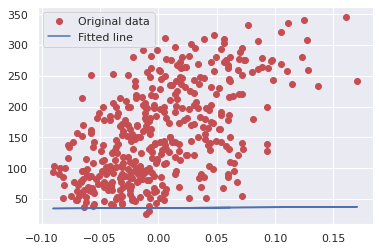

In [107]:
# Graphic display *after* training
W, b = [np.asscalar(v) for v in model.layers[0].get_weights()]

# The coefficients
print('Coefficients: \n', b)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))


plt.plot(diabetes_X_train, diabetes_y_train, 'ro', label='Original data')
plt.plot(diabetes_X_train, W * diabetes_X_train + b, label='Fitted line')
plt.legend()
plt.show()

In [108]:
score =model.evaluate(diabetes_X_test, diabetes_y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 0.00%


In [109]:
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [110]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [111]:
# evaluate loaded model on test data
loaded_model.compile(optimizer=keras.optimizers.Adam(lr=0.01), 
              loss='mean_squared_error', metrics=['accuracy'])

In [112]:
score = loaded_model.evaluate(diabetes_X_test, diabetes_y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 0.00%


# E2E ML Project

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [113]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get the data

UUID - #S12C1

In typical environments your data would be available in a relational database (or some other common datastore) and spread across multiple tables/documents/files.

To access it, you would first need to get your credentials and access authorizations, and familiarize yourself with the data schema.

In this project, however, things are much simpler: you will just download a single compressed file, housing.tgz, which contains a comma-separated value (CSV) file called housing.csv with all the data.

You could use your web browser to download it, and run tar xzf housing.tgz to decompress the file and extract the CSV file, but it is preferable to create a small function to do that. It is useful in particular if data changes regularly, as it allows you to write a small script that you can run whenever you need to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals).

Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [114]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/vfp1/bts-dsf-2020/main/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "data/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [115]:
fetch_housing_data()

**YOUR TURN**: create a function to load the CSV into Pandas. Make it return a **PandasDataframe**

In [116]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [117]:
data = load_housing_data()

In [118]:
for i, j in data.iterrows(): 
    print(i) 
    print(j) 

Streaming output truncated to the last 5000 lines.
total_rooms             2199
total_bedrooms           358
population               942
households               353
median_income         5.0393
median_house_value    321100
ocean_proximity       INLAND
Name: 6683, dtype: object
6684
longitude            -118.07
latitude               34.16
housing_median_age        39
total_rooms             1804
total_bedrooms           265
population               730
households               276
median_income         6.4761
median_house_value    397500
ocean_proximity       INLAND
Name: 6684, dtype: object
6685
longitude            -118.07
latitude               34.16
housing_median_age        35
total_rooms             2459
total_bedrooms           438
population               970
households               437
median_income         4.2143
median_house_value    369400
ocean_proximity       INLAND
Name: 6685, dtype: object
6686
longitude            -118.07
latitude               34.15
housing_median_

KeyboardInterrupt: ignored

### Looking at the Data Structure

**YOUR TURN**: print the head() of the Pandas *DataFrame*

In [119]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can see a list of quite good attributes to derive the price:


*   Longitude
*   Latitude
*   Housing Median Age
*   Total rooms
*   Total bedrooms
*   Population
*   Household
*   Median Income
*   Median House Value
*   Ocean Proximity



**YOUR TURN**: use the info method to retrieve some information about the dataset. Will this dataset fit in memory?



In [120]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**YOUR TURN**: it seems that all datasets are numerical, but there is one which is an object. It should surely be some sort of text, perhaps a category. Try to check which categories those are and how many districts belong to that category by using the `value_counts()` method:

In [121]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

YOUR TURN: print a statistical summary of the whole dataset. Compare the counts, are there any null values? Hint: look at the count for each column. 

In [122]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**YOUR TURN**: graphically describe the dataset by plotting it. Hint, use the hist() method over the whole dataset (from matplotlib)

Remember that the hist() method relies on Matplotlib, which in turn relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command %matplotlib inline. This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend. Plots are then rendered within the notebook itself. Note that calling show() is optional in a Jupyter notebook, as Jupyter will automatically display plots when a cell is executed.

Saving figure attribute_histogram_plots


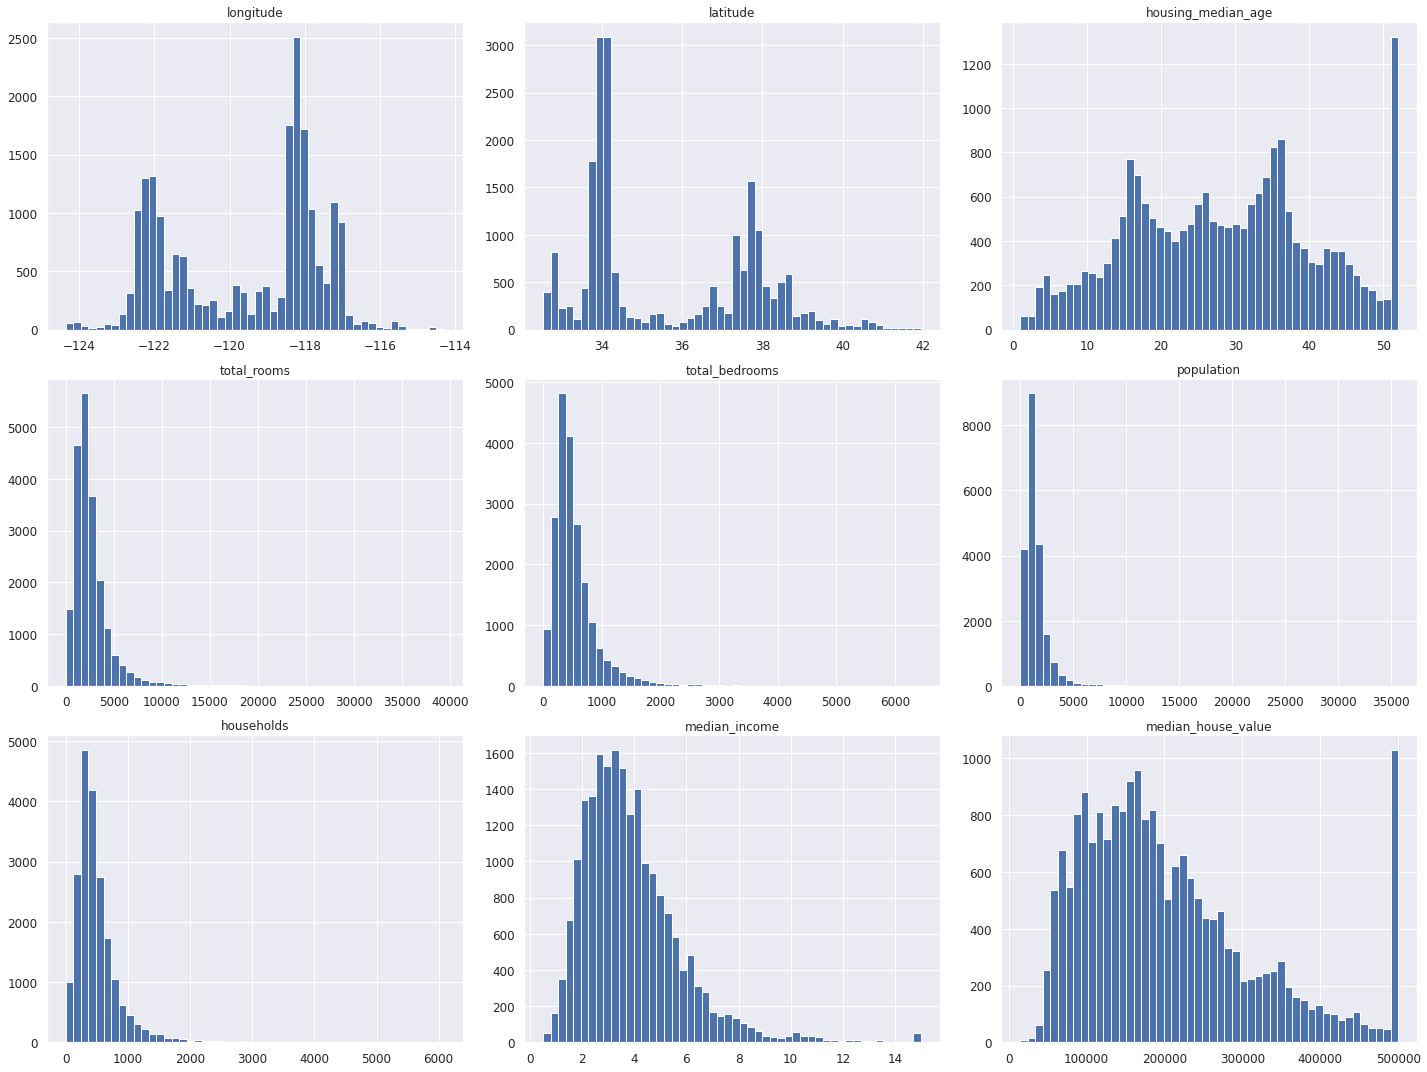

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

**YOUR TURN**: let's discuss all together the implications of this graphs. 


1.   Is the median income expressed in dollars?
2.	And the median age and house value? How are they expressed?
3.	Do all the attributes have the same scale?
4.	Most of histograms are skewed... how would this affect learning?




Some hints and notes


1.   First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
2.	The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000 dollars, then you have mainly two options:
    * Collect proper labels for the districts whose labels were capped.
    * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond
$500,000).
3.	These attributes have very different scales. We will discuss this later in this class when we explore feature scaling.
4.	Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.




### Create a test set

It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? 

This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind  of Machine Learning model. 

When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called data **snooping bias.**

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:


**YOUR TURN**: split the dataset into training and testing, making sure that every time that your pipeline runs this split, it will get the same splits, in order to get experiment consistency. Go ahead and print the head of the test set. Do you have any NANs?

In [124]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [125]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [126]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### The problem with stratified sampling

So far we have considered purely **random sampling** methods. This is **generally fine if your dataset is large enough (especially relative to the number of attributes)**, but if it is not, you run the risk of introducing a **significant sampling bias**. 

When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. 

This is called **STRATIFIED SAMPLING**: the population is divided into homogeneous subgroups called **strata**, and **the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population**. 

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. It is a variable that defines population composition in this dataset as well as female/male does for the US population. You may want to ensure that  the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. 

**YOUR TURN**: go ahead and plot a histogram of median_income variable

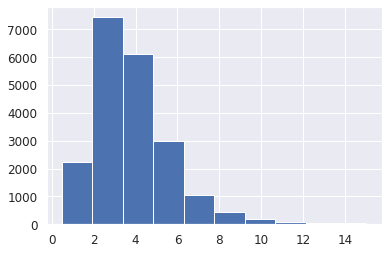

In [127]:
housing["median_income"].hist()

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. 

This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories of median income (labels 1 to 5):


In [128]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [129]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

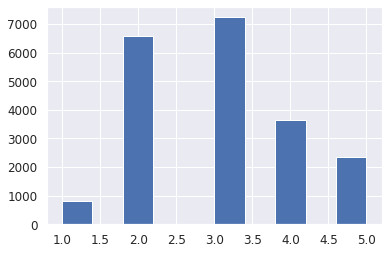

In [130]:
housing["income_cat"].hist()

Now we are ready to do stratified sampling based on the income category that we have just created using StratifiedShuffleSplit class:

In [131]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's check the propoertions of income category proportions in the **overall dataset**, in the test set generated with **stratified sampling**, and in a test set generated using **purely random sampling**. 

As you can see, the **test set generated using stratified sampling has income category proportions almost identical to those in the full dataset**, whereas the test set generated using purely random sampling is quite skewed.

In [132]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [133]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Now let's drop the income_cat attribute from the stratified sets, since we only needed it for actually stratifying the dataset

In [134]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize the data to gain insights

UUID - #S12C2

### Visuallyzing geographical data

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. 

In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [135]:
housing = strat_train_set.copy()

**YOUR TURN**: plot a simple plot of the dataset using its longitude and latitude. Try to make it in a way so that you can reveal some information and patterns (population, house prices) in the same plot. Remember the geoplots we did in previous sessions.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Saving figure bad_visualization_plot


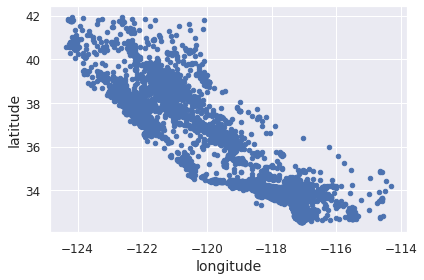

In [136]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Saving figure better_visualization_plot


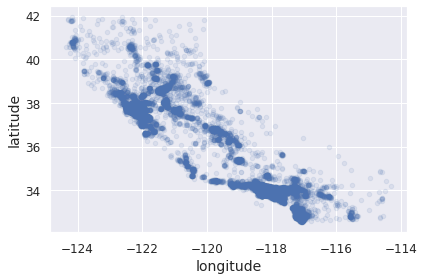

In [137]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


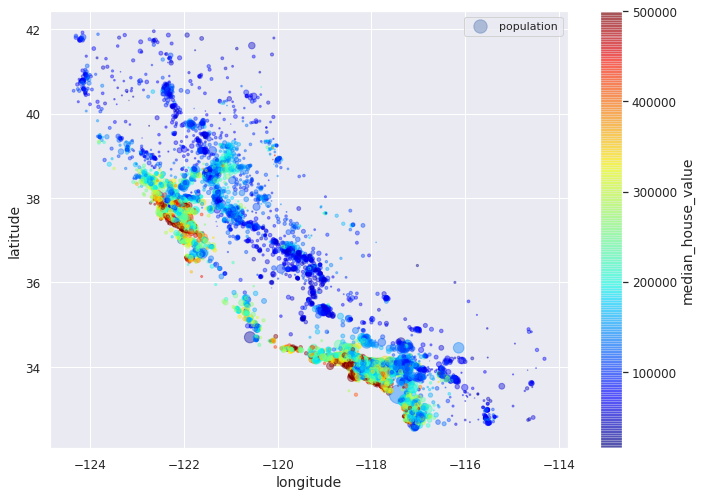

In [138]:
"""
The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). 
This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). 
"""

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

If you plot it correctly, you will see that there are different patterns and areas of different price density. You will see that houses are more expensive as they get closer and closer to ocean and where there is a lot of population.

It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean prox‐ imity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

### Looking for correlations

Since the dataset is not too large, you can easily compute the standard correlation  coefficient (also called `Pearson’s r`) between every pair of attributes using the `corr()` method:

In [139]:
corr_matrix = housing.corr()

You can see how each variable correlates with "median_house_value" which is what is interesting for us:

In [140]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. 

When it is **close to 1**, it means that there is a strong **positive correlation**; for example, the median house value tends to go up when the median income goes up. When the **coefficient is close to –1**, it means that there is a **strong negative correlation**; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

Below there is an image witht he standart correlation coefficient (Pearson's r) of various datasets

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/400px-Correlation_examples2.svg.png)

**YOUR TURN**: use scatter_matrix from pandas.plotting to plot graphs that depict the correlation for the following attributes:

*   "median_house_value"
*   "median_income"
*   "total_rooms"
*   "housing_median_age"




Saving figure scatter_matrix_plot


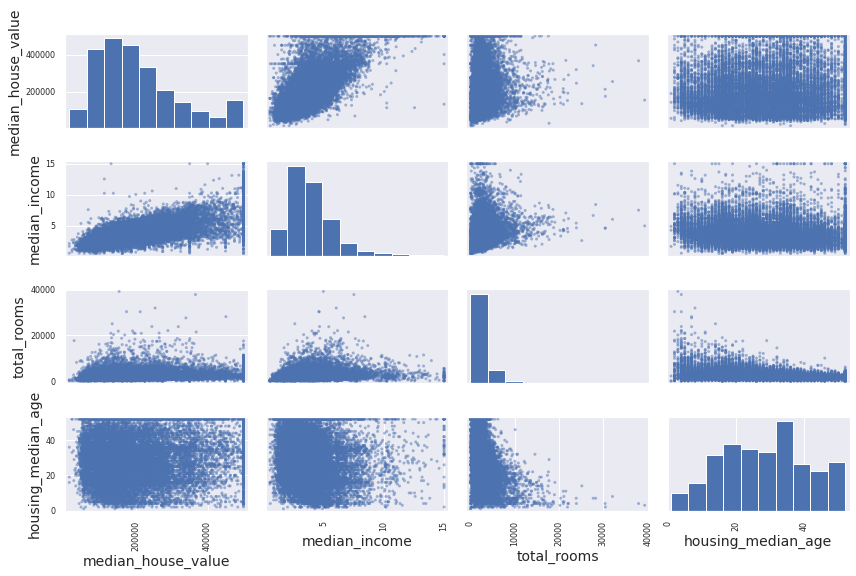

In [141]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

**IMPORTANT!** The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). 

**Note how all the plots of the bottom row have a correlation coefficient equal to zero despite the fact that their axes are clearly not independent**: these are examples of nonlinear relationships. 


**YOUR TURN**: pick the one of the best correlations that you see (for instance median_income vs median_house_value), plot a single scatter plot of it and try to explain the following:

*   What is the straight line above at 500.000 dollars? Our team told us that the dataset had a market cap at that level. Could it be that?
*   What about other price caps? At 450k, 350k... would that hurt our algorithm?
*   Could this be a **data quirk** that we might want to clean up?





*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Saving figure income_vs_house_value_scatterplot


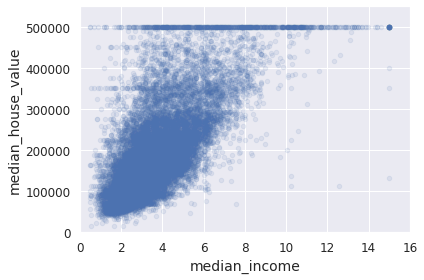

In [142]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

### Experimenting with attribute combinations

Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute. 

You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm). Of course, your mileage will vary considerably with each project but the general ideas are similar.

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various **attribute combinations**. For example, **the total number of rooms in a district is not very useful if you don’t know how many households there are**. 

***What you really want is the number of rooms per household***. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:


In [146]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

**YOUR TURN**: recreate the correlation matrix with the new values. What did you find? Try to plot it. 

Is the new *bedrooms_per_room* more or less correlated with median_house than the total number of rooms or bedrooms?

In [147]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


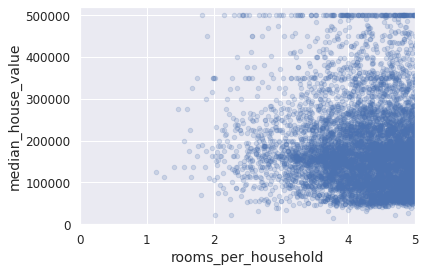

In [148]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

**This round of exploration does not have to be absolutely thorough**; the **POINT** is to **start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype**. 

But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.


## Prepare the data for Machine Learning algorithms

UUID - #S12C3

It’s time to prepare the data for your Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons:
*	This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
*	You will gradually build a library of transformation functions that you can reuse in future projects.
*	You can use these functions in your live system to transform the new data before feeding it to your algorithms.
*   This will make it possible for you to easily try various transformations and see which combination of transformations works best.

### Data cleaning

First let’s revert to a clean training set (by copying strat_train_set once again), and **let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values** (note that drop() creates a copy of the data and does not affect strat_train_set):


In [150]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

**YOUR TURN**: check if we have any rows that has missing values (NaN)

In [151]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Yikes! Indeed we do. That's a problem.

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You might have noticed that the *total_bedrooms* attribute has some missing values, so let’s fix this. You have three options:

*	Get rid of the corresponding districts.
*	Get rid of the whole attribute.
*	Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s **dropna()**, **drop()**, and **fillna()**
methods:


**YOUR TURN**: use any of the methods and see what it yields. 

Beware that if you use fillna() you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [152]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [153]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [154]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [155]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


### Using Imputer: a simpler way

Scikit-Learn provides a handy class to take care of missing values: Imputer. Here is how to use it. First, you need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute.

However, the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity.

In [156]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [157]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [158]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The **Imputer** has simply computed the **median of each attribute and stored the result in its statistics_ instance variable**. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so **it is safer to apply the imputer to all the numerical attributes**

In [159]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [160]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [161]:
X = imputer.transform(housing_num)

The result is a plain Numpy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:

In [162]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [163]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [164]:
imputer.strategy

'median'

### Handling text and categorical attributes

But wait a second, what about our *ocean_proximity* variable?

We need to convert it to labels and put it back to the DataFrame. Anyone remembers how to do it? OneHotEncoders, OrdinalEncoders... you name it.

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [165]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


**YOUR TURN**: use OneHotEncoder from sklearn.preprocesing and fit_transform the variable. Print some of the entries.

In [166]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [167]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [168]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

You can access the categories from OneHotEncoder as such

In [169]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Transformers are part of Sklearn's API, the transformation is performed by the transform() method with the dataset to transform as a parameter. It returns the transformed dataset. This transforma‐
tion generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called fit_transform(), which directly fits and transforms the data.

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

You can get the last one for free by simply adding `TransformerMixin` as a base class. Also, if you add `BaseEstimator` as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:


In [170]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [171]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household", "bedrooms_per_room"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


In [172]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In this example the transformer has one hyperparameter, *add_bedrooms_per_room*, set to *True* by default (it is often helpful to provide sensible defaults). 

This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. 

The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

### Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1.

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the result‐ ing distribution has unit variance.


**YOUR TURN**: Build a PREPROCESSING PIPELINE that will include:


*   Imputer
*   The CombinedAttributesAdder() we just wrote
*   A StandardScaler

Apply fit transform to it



In [173]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [174]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [175]:
housing_num_tr.min()

-2.704541614772787

In [176]:
housing_num_tr.max()

107.06025791500451

Wait, we have handled the numerical columns and categorical columns separately. But what about our ocean proximity variable?

We can build a pipeline using ColumnTransformer in order to finish up applying the OneHotEncoding to the pipeline. 

In this case, the constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names or indices of columns that the transformer should be applied to.

In [177]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [178]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [179]:
housing_prepared.shape

(16512, 16)

In [180]:
housing_prepared.min()

-2.704541614772787

In [181]:
housing_prepared.max()

107.06025791500451

## Full preprocessing pipeline

**YOUR TURN**: apply the full pipeline and get an array ready for ML

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline_fulltest = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr_fulltest = num_pipeline_fulltest.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline_fulltest = ColumnTransformer([
        ("num", num_pipeline_fulltest, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared_fulltest = full_pipeline_fulltest.fit_transform(housing)

In [183]:
housing_prepared_fulltest

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and train a model 

UUID - #S12C4

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model



### Training and Evaluating on the Training Set

Thanks to all our hard work, now it is extremely simple to deal with this dataset.

First, let's train a LinearRegression, using the datasets used above.

In [184]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now let's try few instances from the training set to do some inferences. We just skip through all the crazy data wrangling and just apply the pipeline we created.

In [185]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [186]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works more or less but we could certify it using the metrics we thought about before.

In [187]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [188]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

**YOUR TURN**: find a regressor that you see fit for this dataset, from the ones that you saw in CDA. Also apply a K-fold cross validation, so that you are sure about accuracy

In [189]:
# Some utils functions for displaying scores

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [190]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [191]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [192]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [193]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

## Keeping your experiments saved

You should save every model you experiment with, so you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. You can easily save Scikit-Learn models by using Python’s pickle module, or using sklearn.externals.joblib, which is more efficient at serializing large NumPy arrays

In [194]:
import joblib
joblib.dump(forest_reg, "forest_reg.pkl") # DIFF
#...
forest_reg_loaded = joblib.load("forest_reg.pkl") # DIFF

## Fine-tune your model

UUID - #S12C5

Using our beloved GridSearchCV

**YOUR TURN**: apply different combinations of parameters to get the most out of your algorithm using GridSearchCV

In [195]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

The best hyperparameter combination found:

In [196]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [197]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [198]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [199]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.077358,0.004959,0.004434,0.000071,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.243633,0.004422,0.012027,0.000287,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.731993,0.005880,0.033865,0.001434,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.121118,0.001415,0.004424,0.000094,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.403674,0.004522,0.012706,0.001356,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.199139,0.005892,0.032816,0.000580,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.165333,0.004726,0.004432,0.000073,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.549069,0.003887,0.011935,0.000100,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.695071,0.014126,0.034566,0.001428,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.214974,0.002937,0.004478,0.000147,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## Introducing RandomizedSearchCV

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. 

This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

*	If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few val‐ ues per hyperparameter with the grid search approach).
*	You have more control over the computing budget you want to allocate to hyper‐ parameter search, simply by setting the number of iterations.


In [200]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [201]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Models and their errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to under‐ stand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).


## Evaluate your final system on the test set

**YOUR TURN**: evaluate the final system on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()!), and evaluate the final model on the test set. Print the performance metrics that you have chosen. 

In [202]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [203]:
final_rmse

47730.22690385927

## A full pipeline with both preparation and prediction and model persistence

**YOUR TURN**: wrap it all up and create a pipeline that prepares data and applies your algorithm. Then run and fit and predict some data through it. Alternatively, save model with joblib for next time.

In [204]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [205]:
my_model = full_pipeline_with_predictor

In [206]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

In [207]:
my_model_loaded.fit(housing, housing_labels)
my_model_loaded.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])